In [1]:
import json
import uproot
from XRootD import client
import xgboost as xgb
import os
import sys
sys.path.append("../../analysisTools/")
from skimmerTools import Skimmer
from analysisTools import Analyzer
from analysisTools import loadSchema
import plotTools as ptools
import coffea
import coffea.util as util
import numpy as np
import awkward as ak
import time
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
import glob
import hist
import matplotlib as mpl


### Run preselections (up to dPhiMET cut) and produce coffea

In [2]:
cuts_config = "./preselections.py"
histos_config = "../../configs/histo_configs/SR_studies.py"

In [3]:
if not os.path.isdir('coffea'):
    os.mkdir('coffea')

outdir = "./coffea/skimmed/"
if not os.path.isdir(outdir):
    os.mkdir(outdir)

In [4]:
sample_config = "./skimmed_sig_v2_mA_3m1_2018_aEM.json"

In [5]:
test = Analyzer(sample_config,histos_config,cuts_config, max_samples=-1) # run over all samples in the config

t1 = time.time()
out = test.process(execr='futures')
t2 = time.time()

print("Runtime: {:.2f} minutes".format((t2-t1)/60))
util.save(out,f"{outdir}/signal_SR_BDT_preselections_skimmed.coffea")

del out, test

Output()

Output()

Runtime: 2.32 minutes


In [40]:
bkg_configs = glob.glob("../../configs/sample_configs/skimmed_bkg*.json")

print(bkg_configs)

['../../configs/sample_configs/skimmed_bkg_2018_DY.json', '../../configs/sample_configs/skimmed_bkg_2018_Diboson.json', '../../configs/sample_configs/skimmed_bkg_2018_QCD_TuneCP5_PSWeights.json', '../../configs/sample_configs/skimmed_bkg_2018_TTJetsDiLept.json', '../../configs/sample_configs/skimmed_bkg_2018_Top.json', '../../configs/sample_configs/skimmed_bkg_2018_Triboson.json', '../../configs/sample_configs/skimmed_bkg_2018_WJets.json', '../../configs/sample_configs/skimmed_bkg_2018_ZJets.json']


In [41]:
for bkg in bkg_configs:
    process = bkg.split('/')[-1].split('.json')[0].split('skimmed_')[-1]
    print(process)

    if 'TTJetsDiLept' in bkg: # currently not available ntuples
        continue
    
    test = Analyzer(bkg,histos_config,cuts_config) 
            
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()
            
    print("Runtime: {:.2f} minutes".format((t2-t1)/60))
    util.save(out,f"{outdir}/{process}_SR_BDT_preselections_skimmed.coffea")
    del out, test

bkg_2018_DY


Output()

Output()

Runtime: 0.85 minutes
bkg_2018_Diboson


Output()

Output()

Runtime: 0.58 minutes
bkg_2018_QCD_TuneCP5_PSWeights


Output()

Output()

Runtime: 2.30 minutes
bkg_2018_TTJetsDiLept
bkg_2018_Top


Output()

Output()

Runtime: 3.83 minutes
bkg_2018_Triboson


Output()

Output()

Runtime: 0.27 minutes
bkg_2018_WJets


Output()

Output()

Runtime: 3.12 minutes
bkg_2018_ZJets


Output()

Output()

Runtime: 3.08 minutes


### Process coffea into dataframe and plot

In [5]:
# Signal
sig_histo = util.load(f'{outdir}/signal_SR_BDT_preselections_skimmed.coffea')[0]

sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

# signal efficiencies by delta/ctau
cf_s = sig_histo['cutflow']              # efficiency
ct_s = sig_histo['cutflow_cts']          # xsec-weighted event count
fr_s = sig_histo['cutflow_vtx_matched'] # fraction that selected vtx is truth-matched, for signal
desc = sig_histo['cutDesc']

# signal efficiencies, when only looking at the events where the gen ee are reconstructed (dR(gen,reco) < 0.1)
cf_s_reco = sig_histo['cutflow_genEEreconstructed']              # efficiency
ct_s_reco = sig_histo['cutflow_cts_genEEreconstructed']          # xsec-weighted event count
fr_s_reco = sig_histo['cutflow_vtx_matched_genEEreconstructed']  # fraction that selected vtx is truth-matched, for signal

cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig_histo['cutDesc'][cname]) for cname in sig_histo['cutDesc'].keys()}

deltas = sorted(list(set(si.delta)))

In [6]:
sig_columns = list(cf_s.keys())
sig_efficiency = {c: [ cf_s[samp][c] for samp in sig_columns ] for c in cuts}
sig_match = {c: [ fr_s[samp][c] for samp in sig_columns ] for c in cuts}

sig_eff_df = pd.DataFrame.from_dict(sig_efficiency).transpose()
sig_eff_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_eff_df.index = cut

In [7]:
sig_counts = {c: [ ct_s[samp][c] for samp in sig_columns ] for c in cuts}

sig_cts_df = pd.DataFrame.from_dict(sig_counts).transpose()
sig_cts_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_cts_df.index = cut

In [8]:
sig_match_df = pd.DataFrame.from_dict(sig_match).transpose()
sig_match_df.columns = sig_columns

labels = [cutNames[c] for c in cuts]
# Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))

sig_match_df.index = cut

In [9]:
# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD after OSSF cut
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{outdir}/{bkg_files[b]}_SR_BDT_preselections_skimmed.coffea')[0]
    histograms = list(bkg_histos[b].keys())

bkg = {}

for h in histograms:
    bkg[h] = {}
    for b in bkg_histos.keys():
        if type(bkg_histos[b][h]) == hist.Hist and bkg_histos[b][h].sum(flow=True).value > 0:
            bkg[h][b] = bkg_histos[b][h][{"samp":sum}]

# sort the histograms by the entries
hname = 'sel_vtx_minDxy'

cut = 'cut9'
rebin = 5j

for b in bkg_histos.keys():
    entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}

sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))
print(sorted_entries)

bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}
    
nb = len(bkg_stack.keys())
hb = hist.Stack.from_dict(bkg_stack)

{'W+jets': 11204.390249389457, 'Z+jets': 6256.761405692319, 'QCD': 632.250424861908, 'DY': 455.6547508239746, 'Top': 294.0013522002846, 'Diboson': 189.35027223825455, 'Triboson': 2.0868917726911604}


In [49]:
def plot_bkg(hname, cut, rebin=1j, doLog=True, xlim = [], title='', doDensity=False, doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}
    
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=doDensity, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

    plt.title(title)
    if doDensity:
        plt.ylabel('A.U.')
    else:
        plt.ylabel('Events/{:.2f}'.format(binwidth))
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

In [11]:
def plot_efficiency_signal_varying_M1(df_sig, dict_eff, cuts, cutNames, delta, ct, ylim = [1e-5,5e-2], ylabel='Efficiency', doLegend=True, doLog=True, doSave=False, outDir = 'plots/cutflow/', outName='efficiency.png'):
    m1s = sorted(list(set(df_sig[(df_sig.delta==delta)&(df_sig.ctau==ct)].m1)))
        
    for m1 in m1s:
        pt = df_sig[(df_sig.delta==delta) & (df_sig.m1==m1) & (df_sig.ctau==ct)].name[0]
        effs = [dict_eff[pt][cut] for cut in cuts]
        plt.plot(np.arange(len(cuts)), effs, label=r"$M_1 = {0}$ GeV".format(m1), color=f"C{m1s.index(m1)}")

    if doLog:
        plt.yscale('log')

    plt.ylabel(ylabel)
    
    labels = [cutNames[c] for c in cuts]
    # Replace "No cuts" with "Preselections" and "Baseline Selection" with "0 < n(jet) < 3 & n(good vertex) > 0"
    cut = list(map(lambda x: x.replace('Baseline Selection', '0 < n(jet) < 3 & n(good vertex) > 0'), labels))
    cut = list(map(lambda x: x.replace('No cuts', 'Preselections'), cut))
    
    plt.xticks(ticks = np.arange(len(cuts)), labels = cut, rotation = 45, ha = 'right')

    plt.grid()

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))

    plt.ylim(ylim)
    
    if doLegend:
        plt.legend()
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

In [50]:
def plot_sig(hname, cut, delta, m1, ct, rebin=1j, xlim = [], flow_str=None, doDensity=False, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
    hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
    mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=doDensity,ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))

    if doDensity:
        plt.ylabel('A.U.')
    else:
        plt.ylabel(f'Events/{binwidth}')
        
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

In [51]:
def plot_sig_varying_ctau(ax, hname, cut, m1, delta, rebin=1j, xlim = [], flow_str=None, doDensity=False, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.sca(ax)
    
    ct_list = sorted(list(set(si[(si.m1==m1) & (si.delta==delta)].ctau)))
    
    for j, ct in enumerate(ct_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$c\tau = {0}$".format(ct),yerr=False,density=doDensity,ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $M1$ = {1} GeV".format(delta,m1))

    if doDensity:
        plt.ylabel('A.U.')
    else:
        plt.ylabel('Events/{:.2f}'.format(binwidth))

    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

In [52]:
def plot_sig_varying_M1(ax, hname, cut, delta, ct, rebin=1j, xlim = [], flow_str=None, doDensity=False, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.sca(ax)
    
    m1_list = sorted(list(set(si[(si.delta==delta) & (si.ctau==ct)].m1)))
    
    for j, m1 in enumerate(m1_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=doDensity,ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))

    if doDensity:
        plt.ylabel('A.U.')
    else:
        plt.ylabel('Events/{:.2f}'.format(binwidth))
    
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

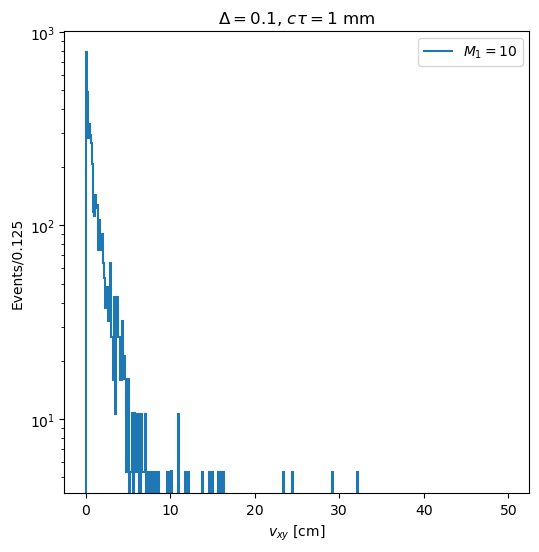

In [14]:
delta = 0.1
m1 = 10
ct = 1
plot_sig('sel_vtx_vxy', 'cut9', delta, m1, ct, rebin=5j)

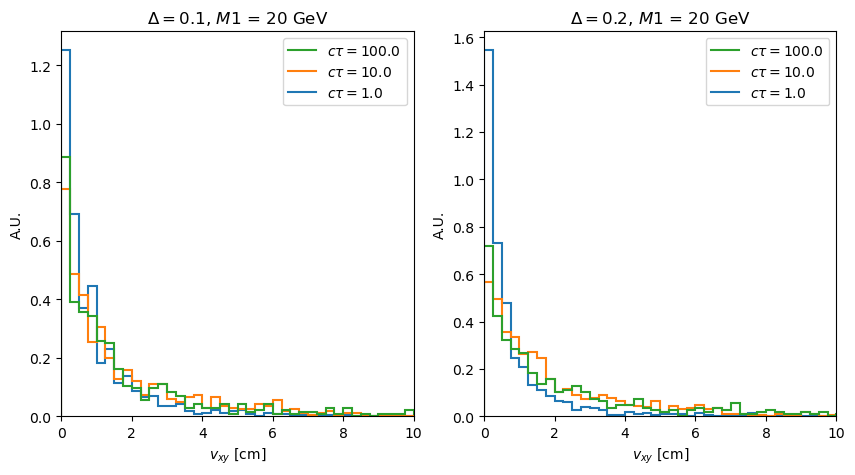

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

delta = 0.1
m1 = 20

for idx, delta in enumerate([0.1, 0.2]):
    plot_sig_varying_ctau(ax[idx], 'sel_vtx_vxy', 'cut9', m1, delta, rebin=10j, doDensity=True, doLog=False, xlim=[0,10])

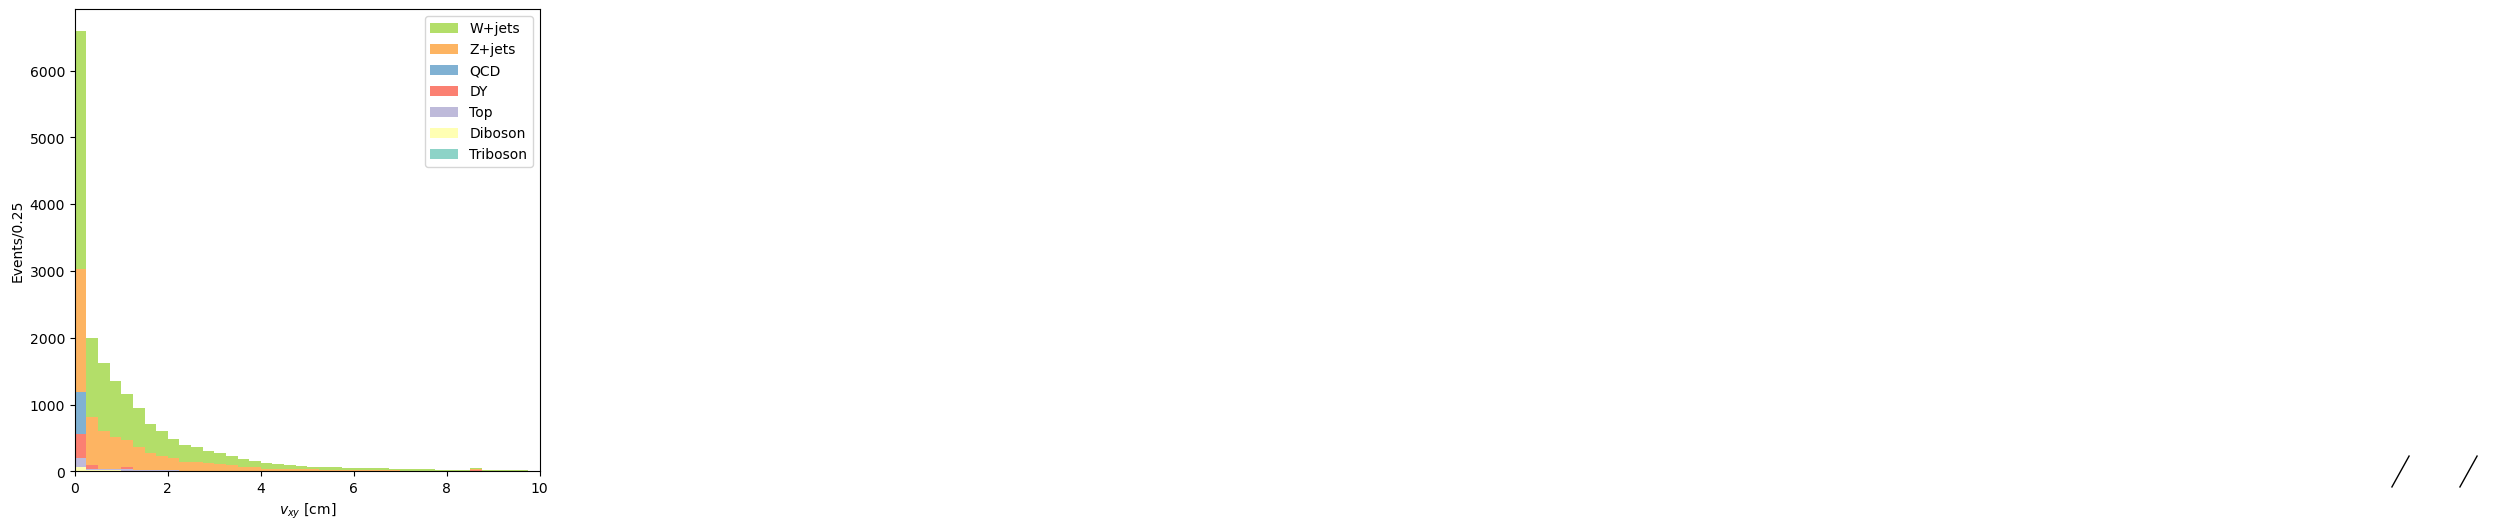

In [93]:
plot_bkg('sel_vtx_vxy', 'cut9', rebin=10j, doDensity=False, doLog=False, xlim=[0,10])

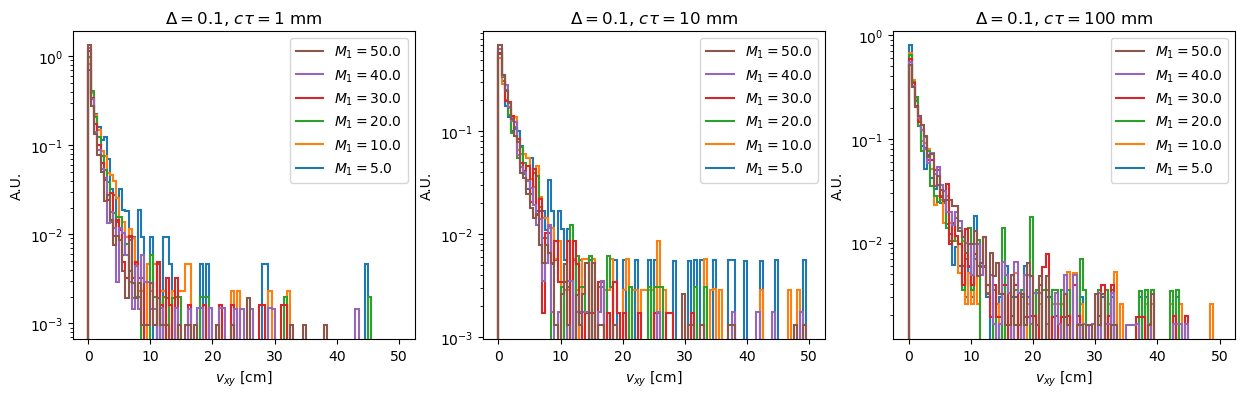

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

delta = 0.1
ctaus = [1,10,100]

for idx, ctau in enumerate(ctaus):
    plot_sig_varying_M1(ax[idx], 'sel_vtx_vxy', 'cut9', delta, ct=ctau, rebin=20j, doDensity=True)

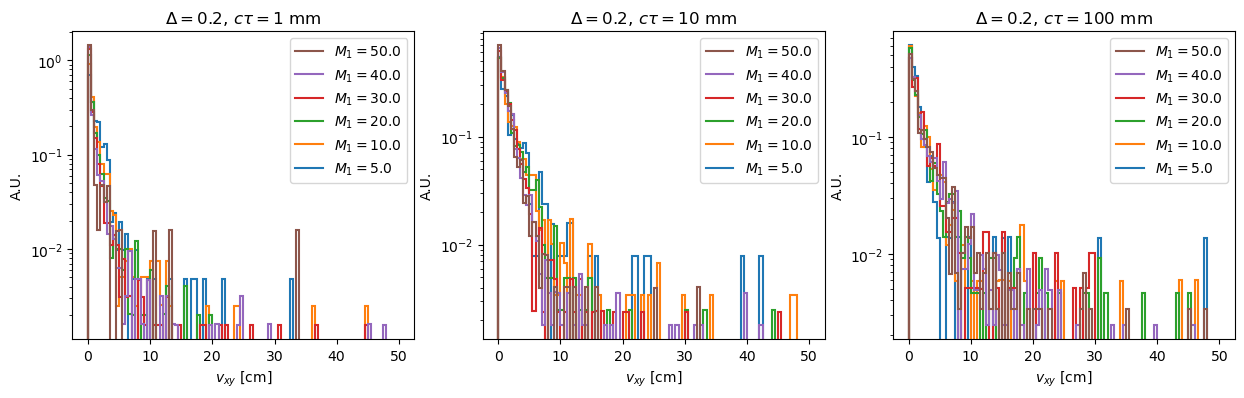

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

delta = 0.2
ctaus = [1,10,100]

for idx, ctau in enumerate(ctaus):
    plot_sig_varying_M1(ax[idx], 'sel_vtx_vxy', 'cut9', delta, ct=ctau, rebin=20j, doDensity=True)

In [60]:
def plot_bkg_sig_varying_M1(ax, hname, cut, delta, ct, rebin=1j, xlim = [], xlabel='', flow_str=None, doDensity=False, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):    
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.sca(ax)
    
    # bkg
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}
    
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=doDensity, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

    # signal
    m1_list = sorted(list(set(si[(si.delta==delta) & (si.ctau==ct)].m1)))
    
    for j, m1 in enumerate(m1_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=doDensity,color=f"C{j}",ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    #plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    if doDensity:
        plt.ylabel('A.U.')
    else:
        plt.ylabel('Events/{:.2f}'.format(binwidth))

    if xlabel != '':
        plt.xlabel(xlabel)
    
    if doLog:
        plt.yscale('log')
    plt.legend()
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    
    if xlim != []:
        plt.xlim(xlim)
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

### sel_vtx_vxy

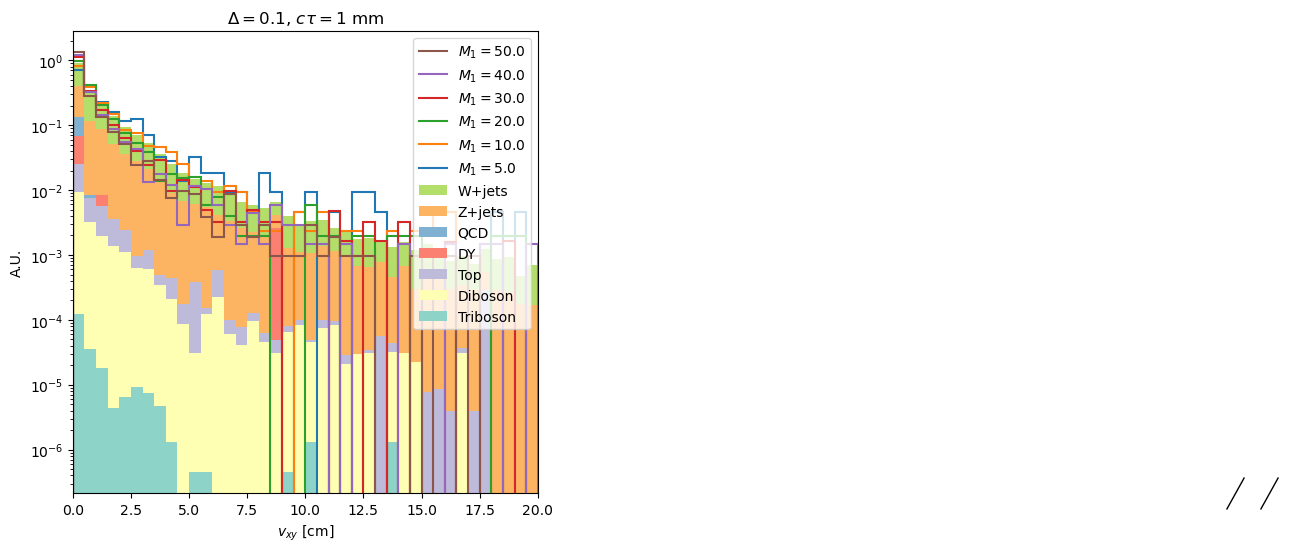

In [86]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta = 0.1
ct = 1

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxy', 'cut9', delta, ct, rebin=20j, doLog=True, doDensity=True, xlim=[0,20])

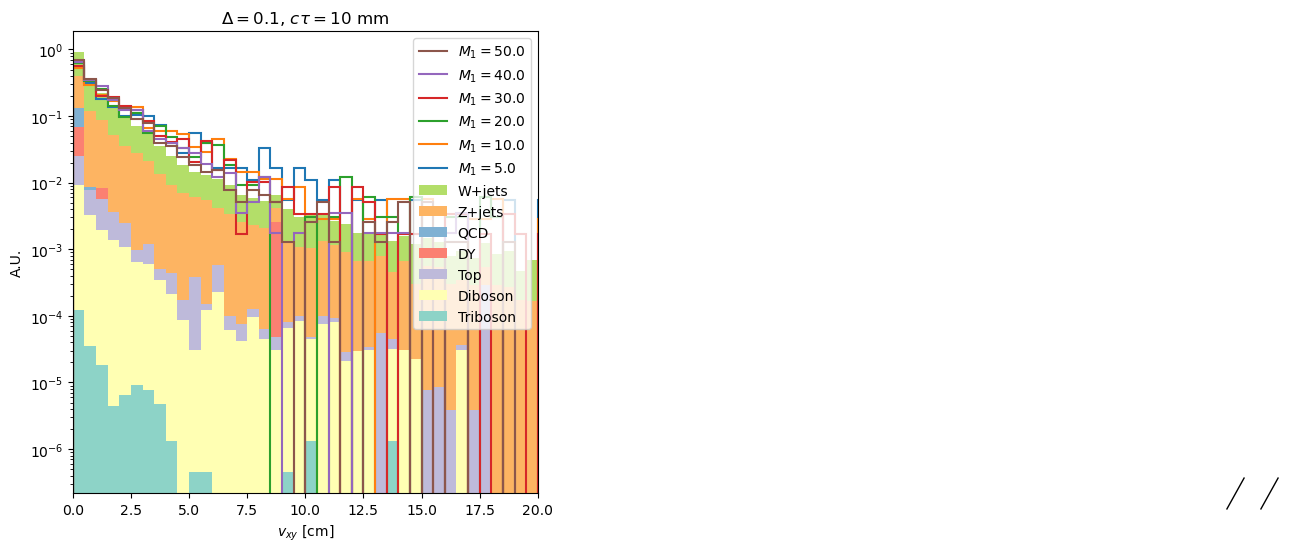

In [87]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta = 0.1
ct = 10

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxy', 'cut9', delta, ct, rebin=20j, doLog=True, doDensity=True, xlim=[0,20])

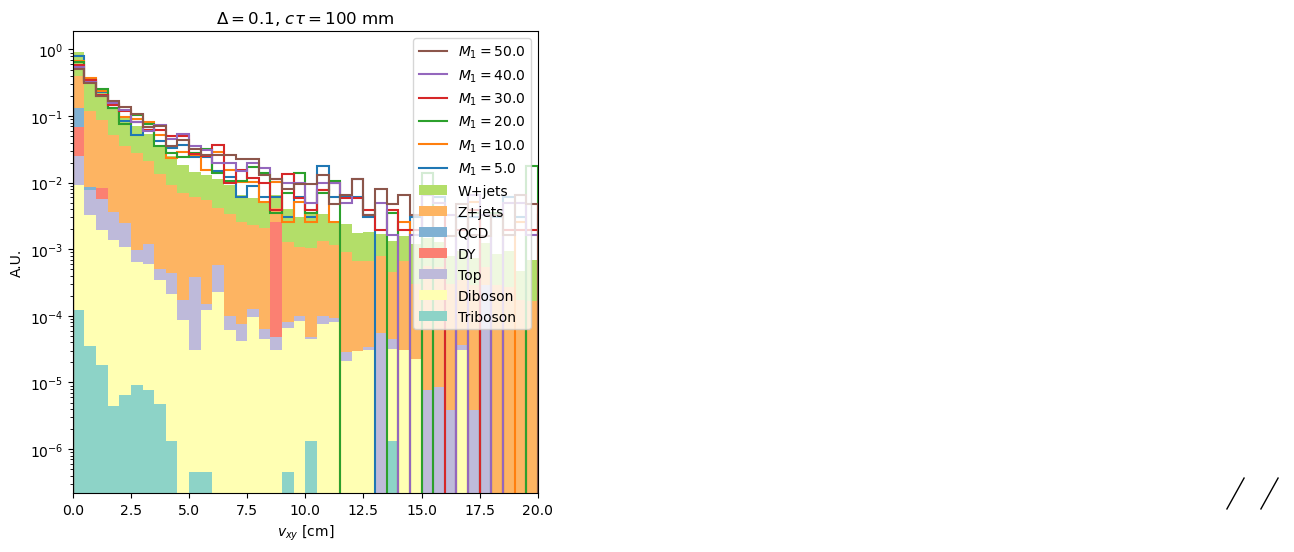

In [89]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta = 0.1
ct = 100

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxy', 'cut9', delta, ct, rebin=20j, doLog=True, doDensity=True, xlim=[0,20])

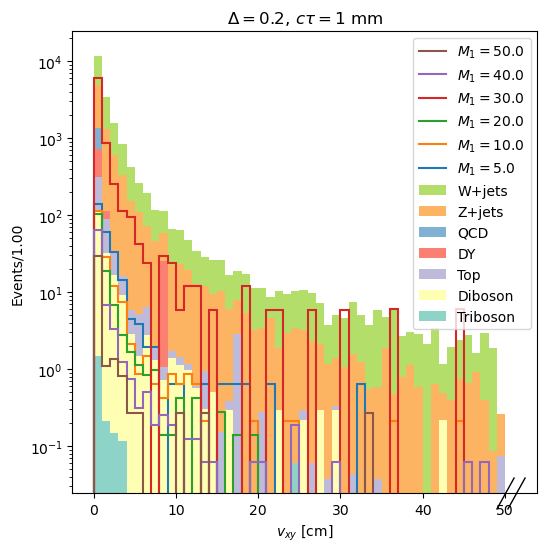

In [22]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta = 0.2
ct = 1

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxy', 'cut9', delta, ct, rebin=40j)

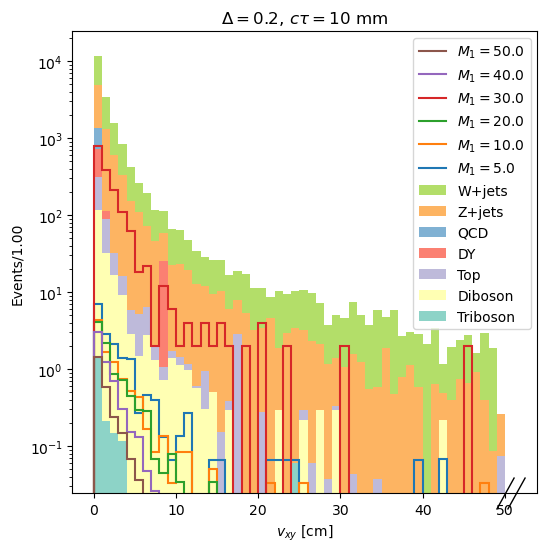

In [23]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta = 0.2
ct = 10

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxy', 'cut9', delta, ct, rebin=40j)

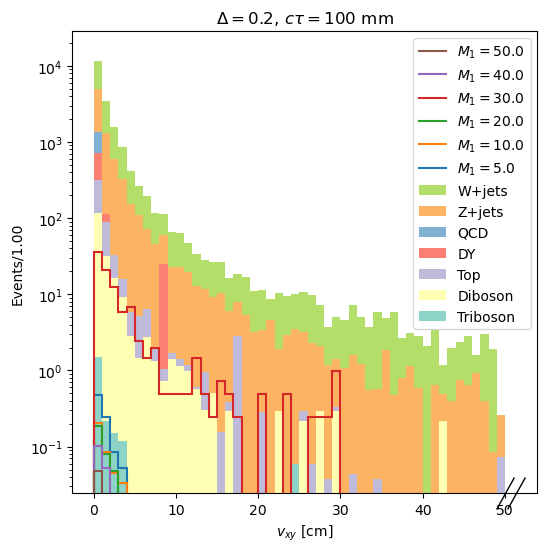

In [24]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta = 0.2
ct = 100

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxy', 'cut9', delta, ct, rebin=40j)

### sel_vtx_vxy_signif

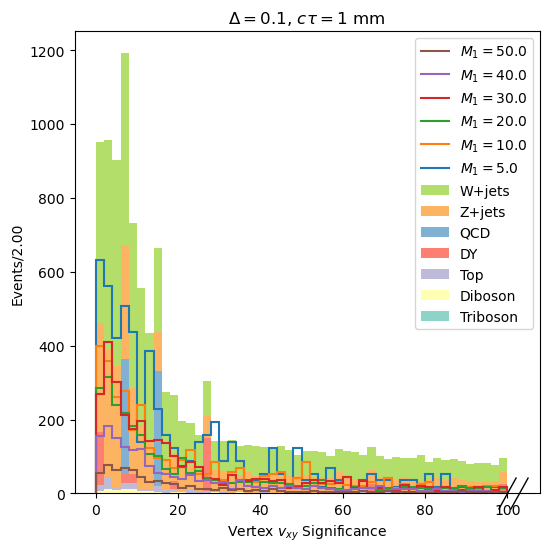

In [25]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta = 0.1
ct = 1

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut9', delta, ct, rebin=2j, doLog=False)

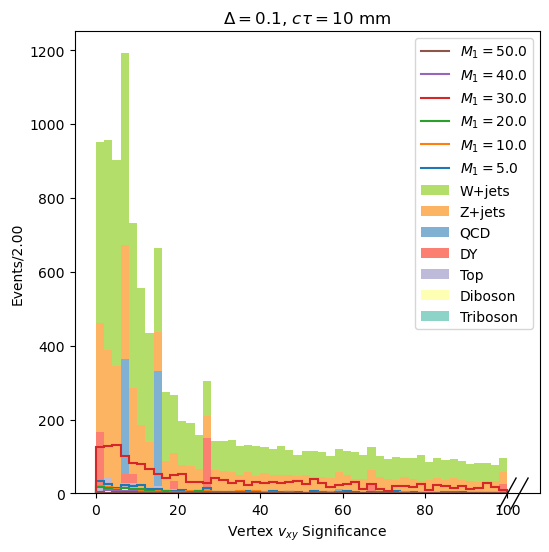

In [26]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta = 0.1
ct = 10

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut9', delta, ct, rebin=2j, doLog=False)

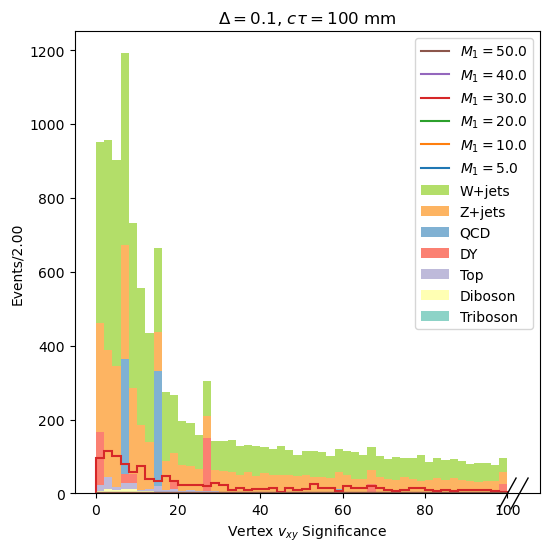

In [27]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta = 0.1
ct = 100

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut9', delta, ct, rebin=2j, doLog=False)

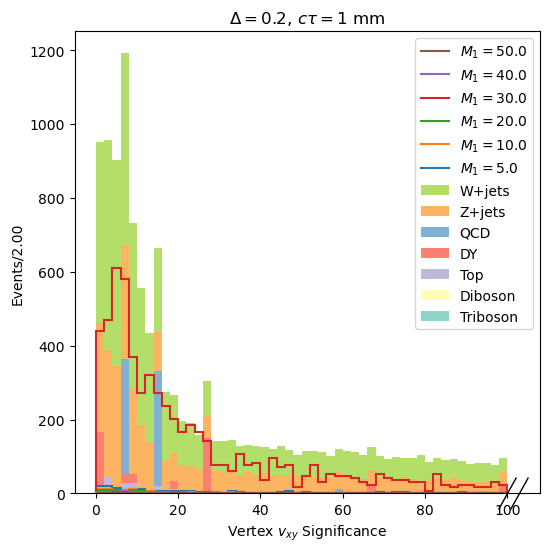

In [28]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta = 0.2
ct = 1

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut9', delta, ct, rebin=2j, doLog=False)

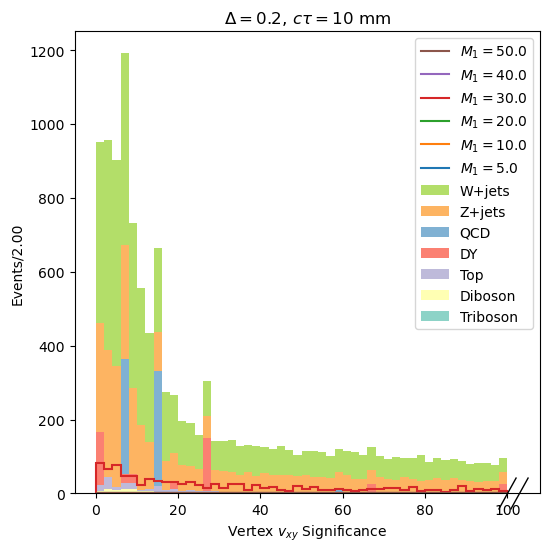

In [29]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta = 0.2
ct = 10

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut9', delta, ct, rebin=2j, doLog=False)

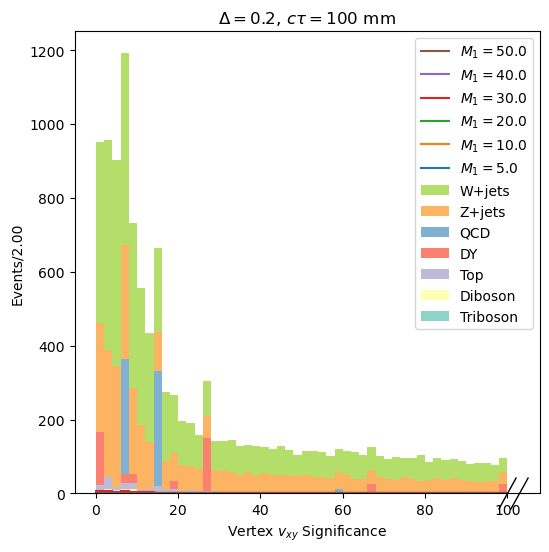

In [30]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta = 0.2
ct = 100

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut9', delta, ct, rebin=2j, doLog=False)

### Run Skimmers on skimmed ntuples with preselections, produce h5 files for BDT input

In [95]:
outdir = "./h5/"
os.system(f"mkdir -p {outdir}")

0

In [96]:
def write_h5(data,fname):
    with h5py.File(fname,'w') as f:
        for k in data.keys():
            arr = data[k].value
            if type(arr) == np.ma.core.MaskedArray:
                arr = arr.data
            f.create_dataset(k,data=arr)

In [97]:
suffix = "_TrueVertexForSignal"

In [98]:
cut_config = "./preselections.py"

In [99]:
sig_sample_json_dir = './'
jsons = [f for f in os.listdir(sig_sample_json_dir) if ".json" in f]

signal_list = [ samp.split('.')[0] for samp in jsons if "skimmed_sig_v2_mA_3m1_2018_aEM" in samp ]
print(signal_list)

bkg_sample_json_dir = '../../configs/sample_configs/'
jsons = [f for f in os.listdir(bkg_sample_json_dir) if ".json" in f]

bkg_list = [ samp.split('.')[0] for samp in jsons if "skimmed_bkg" in samp ]
print(bkg_list)

['skimmed_sig_v2_mA_3m1_2018_aEM']
['skimmed_bkg_2018_DY', 'skimmed_bkg_2018_Diboson', 'skimmed_bkg_2018_QCD_TuneCP5_PSWeights', 'skimmed_bkg_2018_TTJetsDiLept', 'skimmed_bkg_2018_Top', 'skimmed_bkg_2018_Triboson', 'skimmed_bkg_2018_WJets', 'skimmed_bkg_2018_ZJets']


In [100]:
for samp in signal_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{sig_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_sig_v2_mA_3m1_2018_aEM


Output()

Output()

Completed in 1.82 min



In [101]:
for samp in bkg_list:
    if 'TTJetsDiLept' in samp: # currently not available ntuples
        continue
    
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{bkg_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_bkg_2018_DY


Output()

Output()

Completed in 0.79 min

Start analyzing: skimmed_bkg_2018_Diboson


Output()

Output()

Completed in 0.59 min

Start analyzing: skimmed_bkg_2018_QCD_TuneCP5_PSWeights


Output()

Output()

Completed in 2.39 min

Start analyzing: skimmed_bkg_2018_Top


Output()

Output()

Completed in 3.67 min

Start analyzing: skimmed_bkg_2018_Triboson


Output()

Output()

Completed in 0.25 min

Start analyzing: skimmed_bkg_2018_WJets


Output()

Output()

Completed in 2.60 min

Start analyzing: skimmed_bkg_2018_ZJets


Output()

Output()

Completed in 2.43 min

